In [ ]:
!apt install git+https://github.com/UCSD-AI4H/COVID-CT.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package git+https://github.com/UCSD-AI4H
E: Couldn't find any package by glob 'git+https://github.com/UCSD-AI4H'
E: Couldn't find any package by regex 'git+https://github.com/UCSD-AI4H'


In [ ]:
!pip install git+https://github.com/UCSD-AI4H/COVID-CT.git

  Cloning https://github.com/UCSD-AI4H/COVID-CT.git to /tmp/pip-req-build-rw54dpfv
  Running command git clone -q https://github.com/UCSD-AI4H/COVID-CT.git /tmp/pip-req-build-rw54dpfv
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [ ]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
# from torchvision.models.utils import load_state_dict_from_url
import errno
import hashlib
import os
import re
import shutil
import sys
import tempfile
import torch
import warnings
import zipfile


In [ ]:
if sys.version_info[0] == 2:
    from urlparse import urlparse
    import requests
else:
    from urllib.request import urlopen
    from urllib.parse import urlparse  # noqa: F401

try:
    from tqdm import tqdm
except ImportError:
    # fake tqdm if it's not installed
    class tqdm(object):

        def __init__(self, total=None, disable=False,
                     unit=None, unit_scale=None, unit_divisor=None):
            self.total = total
            self.disable = disable
            self.n = 0
            # ignore unit, unit_scale, unit_divisor; they're just for real tqdm

        def update(self, n):
            if self.disable:
                return

            self.n += n
            if self.total is None:
                sys.stderr.write("\r{0:.1f} bytes".format(self.n))
            else:
                sys.stderr.write("\r{0:.1f}%".format(100 * self.n / float(self.total)))
            sys.stderr.flush()

        def __enter__(self):
            return self

        def __exit__(self, exc_type, exc_val, exc_tb):
            if self.disable:
                return

            sys.stderr.write('\n')


In [ ]:
# matches bfd8deac from resnet18-bfd8deac.pth
HASH_REGEX = re.compile(r'-([a-f0-9]*)\.')

MASTER_BRANCH = 'master'
ENV_TORCH_HOME = 'TORCH_HOME'
ENV_XDG_CACHE_HOME = 'XDG_CACHE_HOME'
DEFAULT_CACHE_DIR = '~/.cache'
VAR_DEPENDENCY = 'dependencies'
MODULE_HUBCONF = 'hubconf.py'
READ_DATA_CHUNK = 8192
hub_dir = None


In [ ]:
# Copied from tools/shared/module_loader to be included in torch package
def import_module(name, path):
    if sys.version_info >= (3, 5):
        import importlib.util
        spec = importlib.util.spec_from_file_location(name, path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        return module
    elif sys.version_info >= (3, 0):
        from importlib.machinery import SourceFileLoader
        return SourceFileLoader(name, path).load_module()
    else:
        import imp
        return imp.load_source(name, path)


def _remove_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)


In [ ]:
def _git_archive_link(repo_owner, repo_name, branch):
    return 'https://github.com/{}/{}/archive/{}.zip'.format(repo_owner, repo_name, branch)


def _download_archive_zip(url, filename):
    sys.stderr.write('Downloading: \"{}\" to {}\n'.format(url, filename))
    # We use a different API for python2 since urllib(2) doesn't recognize the CA
    # certificates in older Python
    if sys.version_info[0] == 2:
        response = requests.get(url, stream=True).raw
    else:
        response = urlopen(url)
    with open(filename, 'wb') as f:
        while True:
            data = response.read(READ_DATA_CHUNK)
            if len(data) == 0:
                break
            f.write(data)


In [ ]:
def _load_attr_from_module(module, func_name):
    # Check if callable is defined in the module
    if func_name not in dir(module):
        return None
    return getattr(module, func_name)


def _get_torch_home():
    torch_home = os.path.expanduser(
        os.getenv(ENV_TORCH_HOME,
                  os.path.join(os.getenv(ENV_XDG_CACHE_HOME, DEFAULT_CACHE_DIR), 'torch')))
    return torch_home


In [ ]:
def _setup_hubdir():
    global hub_dir
    # Issue warning to move data if old env is set
    if os.getenv('TORCH_HUB'):
        warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')

    if hub_dir is None:
        torch_home = _get_torch_home()
        hub_dir = os.path.join(torch_home, 'hub')

    if not os.path.exists(hub_dir):
        os.makedirs(hub_dir)


def _parse_repo_info(github):
    branch = MASTER_BRANCH
    if ':' in github:
        repo_info, branch = github.split(':')
    else:
        repo_info = github
#     repo_owner, repo_name = repo_info.split('/')
#     return repo_owner, repo_name, branch


In [ ]:
def _get_cache_or_reload(github, force_reload):
    # Parse github repo information
    repo_owner, repo_name, branch = _parse_repo_info(github)

    # Github renames folder repo-v1.x.x to repo-1.x.x
    # We don't know the repo name before downloading the zip file
    # and inspect name from it.
    # To check if cached repo exists, we need to normalize folder names.
    repo_dir = os.path.join(hub_dir, '_'.join([repo_owner, repo_name, branch]))

    use_cache = (not force_reload) and os.path.exists(repo_dir)

    if use_cache:
        sys.stderr.write('Using cache found in {}\n'.format(repo_dir))
    else:
        cached_file = os.path.join(hub_dir, branch + '.zip')
        _remove_if_exists(cached_file)

        url = _git_archive_link(repo_owner, repo_name, branch)
        _download_archive_zip(url, cached_file)

        with zipfile.ZipFile(cached_file) as cached_zipfile:
            extraced_repo_name = cached_zipfile.infolist()[0].filename
            extracted_repo = os.path.join(hub_dir, extraced_repo_name)
            _remove_if_exists(extracted_repo)
            # Unzip the code and rename the base folder
            cached_zipfile.extractall(hub_dir)

        _remove_if_exists(cached_file)
        _remove_if_exists(repo_dir)
        shutil.move(extracted_repo, repo_dir)  # rename the repo

    return repo_dir


In [ ]:
def _check_module_exists(name):
    if sys.version_info >= (3, 4):
        import importlib.util
        return importlib.util.find_spec(name) is not None
    elif sys.version_info >= (3, 3):
        # Special case for python3.3
        import importlib.find_loader
        return importlib.find_loader(name) is not None
    else:
        # NB: Python2.7 imp.find_module() doesn't respect PEP 302,
        #     it cannot find a package installed as .egg(zip) file.
        #     Here we use workaround from:
        #     https://stackoverflow.com/questions/28962344/imp-find-module-which-supports-zipped-eggs?lq=1
        #     Also imp doesn't handle hierarchical module names (names contains dots).
        try:
            # 1. Try imp.find_module(), which searches sys.path, but does
            # not respect PEP 302 import hooks.
            import imp
            result = imp.find_module(name)
            if result:
                return True
        except ImportError:
            pass
        path = sys.path
        for item in path:
            # 2. Scan path for import hooks. sys.path_importer_cache maps
            # path items to optional "importer" objects, that implement
            # find_module() etc.  Note that path must be a subset of
            # sys.path for this to work.
            importer = sys.path_importer_cache.get(item)
            if importer:
                try:
                    result = importer.find_module(name, [item])
                    if result:
                        return True
                except ImportError:
                    pass
        return False


In [ ]:
def _check_dependencies(m):
    dependencies = _load_attr_from_module(m, VAR_DEPENDENCY)

    if dependencies is not None:
        missing_deps = [pkg for pkg in dependencies if not _check_module_exists(pkg)]
        if len(missing_deps):
            raise RuntimeError('Missing dependencies: {}'.format(', '.join(missing_deps)))


In [ ]:
def _load_entry_from_hubconf(m, model):
    if not isinstance(model, str):
        raise ValueError('Invalid input: model should be a string of function name')

    # Note that if a missing dependency is imported at top level of hubconf, it will
    # throw before this function. It's a chicken and egg situation where we have to
    # load hubconf to know what're the dependencies, but to import hubconf it requires
    # a missing package. This is fine, Python will throw proper error message for users.
    _check_dependencies(m)

    func = _load_attr_from_module(m, model)

    if func is None or not callable(func):
        raise RuntimeError('Cannot find callable {} in hubconf'.format(model))

    return func


In [ ]:
def set_dir(d):
    r"""
    Optionally set hub_dir to a local dir to save downloaded models & weights.
    If ``set_dir`` is not called, default path is ``$TORCH_HOME/hub`` where
    environment variable ``$TORCH_HOME`` defaults to ``$XDG_CACHE_HOME/torch``.
    ``$XDG_CACHE_HOME`` follows the X Design Group specification of the Linux
    filesytem layout, with a default value ``~/.cache`` if the environment
    variable is not set.
    Args:
        d: path to a local folder to save downloaded models & weights.
    """
    global hub_dir
    hub_dir = d


In [ ]:
def list(github, force_reload=False):
    r"""
    List all entrypoints available in `github` hubconf.
    Args:
        github: Required, a string with format "repo_owner/repo_name[:tag_name]" with an optional
            tag/branch. The default branch is `master` if not specified.
            Example: 'pytorch/vision[:hub]'
        force_reload: Optional, whether to discard the existing cache and force a fresh download.
            Default is `False`.
    Returns:
        entrypoints: a list of available entrypoint names
    Example:
        >>> entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
    """
    # Setup hub_dir to save downloaded files
    _setup_hubdir()

    repo_dir = _get_cache_or_reload(github, force_reload)

    sys.path.insert(0, repo_dir)

    hub_module = import_module(MODULE_HUBCONF, repo_dir + '/' + MODULE_HUBCONF)

    sys.path.remove(repo_dir)

    # We take functions starts with '_' as internal helper functions
    entrypoints = [f for f in dir(hub_module) if callable(getattr(hub_module, f)) and not f.startswith('_')]

    return entrypoints


In [ ]:
def help(github, model, force_reload=False):
    r"""
    Show the docstring of entrypoint `model`.
    Args:
        github: Required, a string with format <repo_owner/repo_name[:tag_name]> with an optional
            tag/branch. The default branch is `master` if not specified.
            Example: 'pytorch/vision[:hub]'
        model: Required, a string of entrypoint name defined in repo's hubconf.py
        force_reload: Optional, whether to discard the existing cache and force a fresh download.
            Default is `False`.
    Example:
        >>> print(torch.hub.help('pytorch/vision', 'resnet18', force_reload=True))
    """
    # Setup hub_dir to save downloaded files
    _setup_hubdir()

    repo_dir = _get_cache_or_reload(github, force_reload)

    sys.path.insert(0, repo_dir)

    hub_module = import_module(MODULE_HUBCONF, repo_dir + '/' + MODULE_HUBCONF)

    sys.path.remove(repo_dir)

    entry = _load_entry_from_hubconf(hub_module, model)

    return entry.__doc__


In [ ]:
def load(github, model, *args, **kwargs):
    r"""
    Load a model from a github repo, with pretrained weights.
    Args:
        github: Required, a string with format "repo_owner/repo_name[:tag_name]" with an optional
            tag/branch. The default branch is `master` if not specified.
            Example: 'pytorch/vision[:hub]'
        model: Required, a string of entrypoint name defined in repo's hubconf.py
        *args: Optional, the corresponding args for callable `model`.
        force_reload: Optional, whether to force a fresh download of github repo unconditionally.
            Default is `False`.
        **kwargs: Optional, the corresponding kwargs for callable `model`.
    Returns:
        a single model with corresponding pretrained weights.
    Example:
        >>> model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
    """
    # Setup hub_dir to save downloaded files
    _setup_hubdir()

    force_reload = kwargs.get('force_reload', False)
    kwargs.pop('force_reload', None)

    repo_dir = _get_cache_or_reload(github, force_reload)

    sys.path.insert(0, repo_dir)

    hub_module = import_module(MODULE_HUBCONF, repo_dir + '/' + MODULE_HUBCONF)

    entry = _load_entry_from_hubconf(hub_module, model)

    model = entry(*args, **kwargs)

    sys.path.remove(repo_dir)

    return model


In [ ]:
def _download_url_to_file(url, dst, hash_prefix, progress):
    file_size = None
    # We use a different API for python2 since urllib(2) doesn't recognize the CA
    # certificates in older Python
    if sys.version_info[0] == 2:
        response = requests.get(url, stream=True)

        content_length = response.headers['Content-Length']
        file_size = content_length
        u = response.raw
    else:
        u = urlopen(url)

        meta = u.info()
        if hasattr(meta, 'getheaders'):
            content_length = meta.getheaders("Content-Length")
        else:
            content_length = meta.get_all("Content-Length")
        if content_length is not None and len(content_length) > 0:
            file_size = int(content_length[0])

    # We deliberately save it in a temp file and move it after
    # download is complete. This prevents a local working checkpoint
    # being overriden by a broken download.
    dst_dir = os.path.dirname(dst)
    f = tempfile.NamedTemporaryFile(delete=False, dir=dst_dir)

    try:
        if hash_prefix is not None:
            sha256 = hashlib.sha256()
        with tqdm(total=file_size, disable=not progress,
                  unit='B', unit_scale=True, unit_divisor=1024) as pbar:
            while True:
                buffer = u.read(8192)
                if len(buffer) == 0:
                    break
                f.write(buffer)
                if hash_prefix is not None:
                    sha256.update(buffer)
                pbar.update(len(buffer))

        f.close()
        if hash_prefix is not None:
            digest = sha256.hexdigest()
            if digest[:len(hash_prefix)] != hash_prefix:
                raise RuntimeError('invalid hash value (expected "{}", got "{}")'
                                   .format(hash_prefix, digest))
        shutil.move(f.name, dst)
    finally:
        f.close()
        if os.path.exists(f.name):
            os.remove(f.name)


In [ ]:
__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


In [ ]:
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


In [ ]:
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


In [ ]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=4, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        self.num_features = num_features

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    def change_cls_number(self,num_classes):
        print("Changing Full Connected")
        self.classifier = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [ ]:
def load_state_dict_from_url(url, model_dir=None, map_location=None, progress=True):
    r"""Loads the Torch serialized object at the given URL.
    If the object is already present in `model_dir`, it's deserialized and
    returned. The filename part of the URL should follow the naming convention
    ``filename-<sha256>.ext`` where ``<sha256>`` is the first eight or more
    digits of the SHA256 hash of the contents of the file. The hash is used to
    ensure unique names and to verify the contents of the file.
    The default value of `model_dir` is ``$TORCH_HOME/checkpoints`` where
    environment variable ``$TORCH_HOME`` defaults to ``$XDG_CACHE_HOME/torch``.
    ``$XDG_CACHE_HOME`` follows the X Design Group specification of the Linux
    filesytem layout, with a default value ``~/.cache`` if not set.
    Args:
        url (string): URL of the object to download
        model_dir (string, optional): directory in which to save the object
        map_location (optional): a function or a dict specifying how to remap storage locations (see torch.load)
        progress (bool, optional): whether or not to display a progress bar to stderr
    Example:
        >>> state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
    """
    # Issue warning to move data if old env is set
    if os.getenv('TORCH_MODEL_ZOO'):
        warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')

    if model_dir is None:
        torch_home = _get_torch_home()
        model_dir = os.path.join(torch_home, 'checkpoints')

    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    cached_file = os.path.join(model_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = HASH_REGEX.search(filename).group(1)
        _download_url_to_file(url, cached_file, hash_prefix, progress=progress)
    return torch.load(cached_file, map_location=map_location)


In [ ]:
def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):

    if pretrained:
        number_cls = kwargs['num_classes']
        kwargs['num_classes'] = 1000
        model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
        _load_state_dict(model, model_urls[arch], progress)
        model.change_cls_number(number_cls)
    else:
        model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model


In [ ]:
def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(pretrained=False, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)


def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)


# matches bfd8deac from resnet18-bfd8deac.pth
HASH_REGEX = re.compile(r'-([a-f0-9]*)\.')

MASTER_BRANCH = 'master'
ENV_TORCH_HOME = 'TORCH_HOME'
ENV_XDG_CACHE_HOME = 'XDG_CACHE_HOME'
DEFAULT_CACHE_DIR = '~/.cache'
VAR_DEPENDENCY = 'dependencies'
MODULE_HUBCONF = 'hubconf.py'
READ_DATA_CHUNK = 8192
hub_dir = None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
'''Load LUNA dataset'''

# import h5py
# import numpy as np
# import skimage
# import torch
# from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
# f = h5py.File('all_patches.hdf5','r')
# f.keys()
# img = f['ct_slices'][:]
# label = f['slice_class'][:]
# f.close()
# print(np.shape(img))
# print('b',np.shape(label))
# skimage.io.imshow(img[120])
# print(label[120])
# batchsize=4

# class LungDataset(Dataset):
#     def __init__(self, img, label, transform=None):
#         self.img = img
#         self.label = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         image = PIL_image = Image.fromarray(self.img[idx]).convert('RGB')

#         if self.transform:
#             image = self.transform(image)
#         sample = {'img': image,
#                   'label': int(self.label[idx])}
#         return sample

# trainset = LungDataset(img, label, transform= val_transformer)
# valset = LungDataset(img, label, transform= val_transformer)
# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# modelname = 'medical_transfer'


'Load LUNA dataset'

In [ ]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample




if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/content/drive/My Drive/intricate-art-neural-transfer-master',
                              txt_COVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_COVID (1)/trainCT_COVID.txt',
                              #new_data/newtxt/train.txt
                              txt_NonCOVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_NonCOVID (1)/trainCT_NonCOVID.txt',
                              #old_data/oldtxt/trainCT_NonCOVID.txt
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='/content/drive/My Drive/intricate-art-neural-transfer-master',
                              txt_COVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_COVID (1)/valCT_COVID.txt',
                            #new_data/newtxt/val.txt
                              txt_NonCOVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_NonCOVID (1)/valCT_NonCOVID.txt',
                            #old_data/oldtxt/valCT_NonCOVID.txt
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='/content/drive/My Drive/intricate-art-neural-transfer-master',
                              txt_COVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_COVID (1)/testCT_COVID.txt',
                             #new_data/newtxt/test.txt
                              txt_NonCOVID='/content/drive/My Drive/intricate-art-neural-transfer-master/CT_NonCOVID (1)/testCT_NonCOVID.txt',
                             #old_data/oldtxt/testCT_NonCOVID.txt
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)


425
118
203


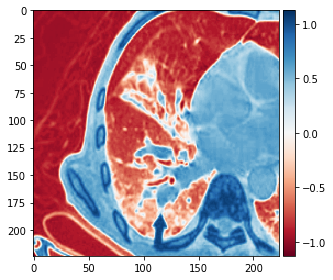

In [ ]:
for batch_index, batch_samples in enumerate(train_loader):
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [ ]:
# mixup
'''Use mixup to do data augmentation'''

# def mixup_data(x, y, alpha=1.0, use_cuda=True):
#     '''Returns mixed inputs, pairs of targets, and lambda'''
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
# #         print('lam',lam)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
# #     print(pred)
# #     print(y_a)
# #     print('criterion',criterion(pred, y_a))
#     return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

'Use mixup to do data augmentation'

In [ ]:
#training process is defined here

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):

    model.train()

    train_loss = 0
    train_correct = 0

    for batch_index, batch_samples in enumerate(train_loader):

        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]

        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)


        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())

        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()

        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))

#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [ ]:
#val process is defined here

def val(epoch):

    model.eval()
    test_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0


    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)

            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()

#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)

    return targetlist, scorelist, predlist

    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [ ]:
#test process is defined here

def test(epoch):

    model.eval()
    test_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0


    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)

            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)


#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist

    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [ ]:
'''CheXNet pretrained model'''

# class DenseNet121(nn.Module):
#     """Model modified.

#     The architecture of our model is the same as standard DenseNet121
#     except the classifier layer which has an additional sigmoid function.

#     """
#     def __init__(self, out_size):
#         super(DenseNet121, self).__init__()
#         self.densenet121 = torchvision.models.densenet121(pretrained=True)
#         num_ftrs = self.densenet121.classifier.in_features
#         self.densenet121.classifier = nn.Sequential(
#             nn.Linear(num_ftrs, out_size),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.densenet121(x)
#         return x


# device = 'cuda'
# CKPT_PATH = 'model.pth.tar'
# N_CLASSES = 14

# DenseNet121 = DenseNet121(N_CLASSES).cuda()

# CKPT_PATH = './CheXNet/model.pth.tar'

# if os.path.isfile(CKPT_PATH):
#     checkpoint = torch.load(CKPT_PATH)
#     state_dict = checkpoint['state_dict']
#     remove_data_parallel = False


#     pattern = re.compile(
#         r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
#     for key in list(state_dict.keys()):
#         match = pattern.match(key)
#         new_key = match.group(1) + match.group(2) if match else key
#         new_key = new_key[7:] if remove_data_parallel else new_key
#         new_key = new_key[7:]
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]


#     DenseNet121.load_state_dict(checkpoint['state_dict'])
#     print("=> loaded checkpoint")
# #     print(densenet121)
# else:
#     print("=> no checkpoint found")

# # for parma in DenseNet121.parameters():
# #         parma.requires_grad = False
# DenseNet121.densenet121.classifier._modules['0'] = nn.Linear(in_features=1024, out_features=2, bias=True)
# DenseNet121.densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# # print(DenseNet121)
# model = DenseNet121.to(device)

'CheXNet pretrained model'

In [ ]:
'''DenseNet121 pretrained model from xrv'''

class DenseNetModel(nn.Module):

     def __init__(self):
         """
         Pass in parsed HyperOptArgumentParser to the model
         :param hparams:
         """
         super(DenseNetModel, self).__init__()

         self.dense_net = xrv.models.DenseNet(num_classes=2)
         self.criterion = nn.CrossEntropyLoss()

     def forward(self, x):
         logits = self.dense_net(x)
         return logits

model = DenseNetModel().cuda()
modelname = 'DenseNet_medical'
print(model)

In [ ]:
'''ResNet18 pretrained'''
# import torchvision.models as models
# model = models.resnet18(pretrained=True).cuda()
# modelname = 'ResNet18'

'ResNet18 pretrained'

In [ ]:
'''Dense121 pretrained'''
# import torchvision.models as models
model = models.densenet121(pretrained=True).cuda()
modelname = 'Dense121'
pretrained_net = torch.load('model_backup/Dense121.pt')
model.load_state_dict(pretrained_net)

NameError: ignored

In [ ]:
### Dense169
 #import torchvision.models as models
# model = models.densenet169(pretrained=True).cuda()
# # # modelname = 'Dense169'

# """load MoCo pretrained model"""
# checkpoint = torch.load('new_data/save_model_dense/checkpoint_luna_covid_moco.pth.tar')
# # # # print(checkpoint.keys())
# # # # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
# #         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'classifier.0.weight':
#         new_key = 'classifier.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.0.bias':
#         new_key = 'classifier.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
#         del state_dict[key]
# state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
# state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
# model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

In [ ]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('model_backup/Dense169.pt')
# pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
pretrained_net = torch.load('model_backup/medical_transfer/medical_transfer_None_LUNA_moco_covid_moco.pt')


model.load_state_dict(pretrained_net)

modelname = 'Dense169_ssl_luna_moco'

NameError: ignored

In [ ]:
'''ResNet50 pretrained'''

# import torchvision.models as models
# model = models.resnet50(pretrained=True).cuda()

# checkpoint = torch.load('new_data/save_model/checkpoint.pth.tar')
# # print(checkpoint.keys())
# # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
#         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'fc.0.weight':
#         new_key = 'fc.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.0.bias':
#         new_key = 'fc.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.2.weight' or key == 'fc.2.bias':
#         del state_dict[key]
# state_dict['fc.weight'] = state_dict['fc.weight'][:1000,:]
# state_dict['fc.bias'] = state_dict['fc.bias'][:1000]
# # print(state_dict.keys())

# # print(state_dict)
# # pattern = re.compile(
# #         r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
# #     for key in list(state_dict.keys()):
# #         match = pattern.match(key)
# #         new_key = match.group(1) + match.group(2) if match else key
# #         new_key = new_key[7:] if remove_data_parallel else new_key
# #         new_key = new_key[7:]
# #         state_dict[new_key] = state_dict[key]
# #         del state_dict[key]

# # model.load_state_dict(checkpoint['state_dict'])

# # # modelname = 'ResNet50'
# modelname = 'ResNet50_ssl'

'ResNet50 pretrained'

In [ ]:
'''VGGNet pretrained'''
# import torchvision.models as models
# model = models.vgg16(pretrained=True)
# model = model.cuda()
# modelname = 'vgg16'

'VGGNet pretrained'

In [ ]:
'''efficientNet pretrained'''

# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
# model = model.cuda()
# modelname = 'efficientNet-b0'


# model = EfficientNet.from_name('efficientnet-b1').cuda()
# modelname = 'efficientNet_random'

'efficientNet pretrained'

In [ ]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

scheduler = StepLR(optimizer, step_size=1)

total_epoch = 3000
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)

    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist
    vote_score = vote_score + scorelist

    if epoch % votenum == 0:

        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum

        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()


        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)



#         if epoch == total_epoch:
        torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



In [ ]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist
vote_score = vote_score + scorelist

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.18472463 0.7080819  0.04646989 0.26989901 0.05336552 0.02941776
 0.02414094 0.59810859 0.36526236 0.43600336 0.84035647 0.50134546
 0.13279232 0.48939028 0.43319929 0.49961865 0.17637068 0.1743184
 0.1379282  0.22343108 0.15364197 0.26578826 0.08987657 0.08548938
 0.13834617 0.26181701 0.16527651 0.12452679 0.09285551 0.06519937
 0.02540484 0.1521637  0.09292986 